# Part 1: How to Explore the GAN Latent Space When Generating Faces (25 pts)

1. Implement SR-GAN on your own using PyTorch. (Ref: https://arxiv.org/abs/1609.04802)

2. Use the ImageNet dataset to run a few epochs to train the model. You may use the script provided here to generate training data: Dataset (https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/srgan/datasets.py). However, there is some issue with this code, hence the drive link for the generated images is shared below. Please use this link to access the dataset for training SRGAN. (https://drive.google.com/drive/folders/13txSH8LU64amnvY0hkxMxMI6F6ssbErG?usp=sharing ) .

Note: you should only use this repo for dataset code and reference. Model and results
(20 pts) + report (5 pts)

In [1]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms


# Configurations

In [2]:
! mkdir trained_model

mkdir: trained_model: File exists


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LOAD_MODEL = True
SAVE_MODEL = True

CHECKPOINT_GEN = "trained_model/gen.pth.tar"
CHECKPOINT_DISC = "trained_model/disc.pth.tar"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
NUM_EPOCHS = 2
BATCH_SIZE = 16
NUM_WORKERS = 4
HIGH_RES = 96
LOW_RES = HIGH_RES // 4
IMG_CHANNELS = 3


base_data_path = "/Users/hims/Downloads/SRGAN_Data/"

# Data Loading And Transformation

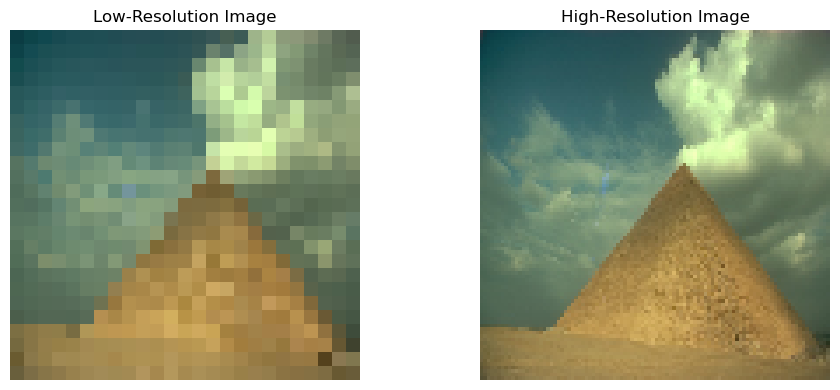

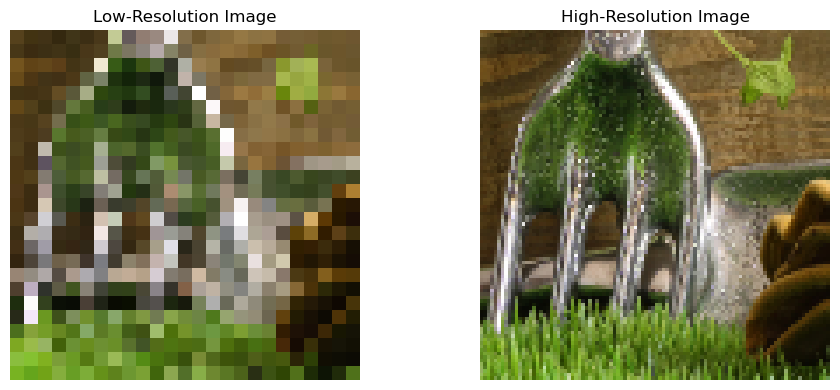

In [4]:
import matplotlib.pyplot as plt

def show_samples(data_path):
    lr_files = os.listdir(data_path + "/LR/")
    hr_files = os.listdir(data_path + "/HR/")
    
    
    for i in range(2):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        image = Image.open(os.path.join(data_path + "/LR/", lr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Low-Resolution Image')

        plt.subplot(1, 2, 2)
        image = Image.open(os.path.join(data_path + "/HR/", hr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('High-Resolution Image')
        
        plt.tight_layout()
        plt.show()        
        
show_samples(base_data_path)

In [5]:
low_res_image = os.listdir(base_data_path + "/LR/")[0]
print("Low Resolution Image size = ", Image.open(os.path.join(base_data_path + "/LR/", low_res_image)).size)

hish_res_image = os.listdir(base_data_path + "/HR/")[0]
print("High Resolution Image size = ", Image.open(os.path.join(base_data_path + "/HR/", hish_res_image)).size)

Low Resolution Image size =  (25, 25)
High Resolution Image size =  (100, 100)


In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImagePairDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_height, hr_height), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

        self.lr_files = sorted(glob.glob(root + "/LR/*.*"))
        self.hr_files = sorted(glob.glob(root + "/HR/*.*"))
        
        print("Image Sizes After transformation")
        print("Low Resolution Image size = ", self.lr_transform(Image.open(self.lr_files[0])).shape)
        print("High Resolution Image size = ", self.hr_transform(Image.open(self.hr_files[0])).shape)

    def __getitem__(self, index):
        img_lr = Image.open(self.lr_files[index])
        img_hr = Image.open(self.hr_files[index])

        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.lr_files) // 2  # Each pair counts as one sample



dataset = ImagePairDataset("/Users/hims/Downloads/SRGAN_Data/", hr_shape=(96, 96))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Image Sizes After transformation
Low Resolution Image size =  torch.Size([3, 24, 24])
High Resolution Image size =  torch.Size([3, 96, 96])


# Model

In [7]:
import torch
from torch import nn


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation_func=None, normalize=True, **kwargs):
        super().__init__()
        self.activation_func = activation_func
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not normalize)
        self.batchNorm = nn.BatchNorm2d(out_channels) if normalize else nn.Identity()

    def forward(self, x):
        out = self.batchNorm(self.cnn(x))
        if self.activation_func is not None:
            out = self.activation_func(out)
        return out
        # return self.act(self.batchNorm(self.cnn(x))) if self.use_act else self.batchNorm(self.cnn(x))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.activation_func = nn.PReLU(num_parameters=in_channels)
        # first three layer of the residual block
        self.block_with_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1, activation_func=self.activation_func)
        # later 2 layer of the residual block
        self.block_wo_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.block_with_act(x)
        out = self.block_wo_act(out)
        return out + x


class PixelShufflerBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        out_channels = in_channels * scale_factor ** 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1) # in_c * 4, H, W --> in_c, H*2, W*2
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.activation_function = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.activation_function(out)
        return out # return self.act(self.pixel_shuffle(self.conv(x)))


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_res_blocks=16, num_pix_shuffle_blocks=2):
        super().__init__()
        self.first_layer = ConvBlock(in_channels, num_channels, activation_func=nn.PReLU(num_parameters=num_channels), kernel_size=9, stride=1, padding=4, normalize=False)
        self.residual_layer = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_res_blocks)])
        self.conv_layer = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle_layer = nn.Sequential(*[PixelShufflerBlock(num_channels, scale_factor=2) for _ in range(num_pix_shuffle_blocks)])
        self.output_layer = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.first_layer(x)
        out = self.residual_layer(initial)
        out = self.conv_layer(out) + initial
        out = self.pixel_shuffle_layer(out)
        out = self.output_layer(out)
        out = torch.tanh(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()

        activation_func = nn.LeakyReLU(0.2, inplace=True)
#         layers = []
#         for idx, feature in enumerate(features):
#             stride = idx % 2 + 1
#             normalize = False if idx == 0 else True
#             layers.append(
#                 ConvBlock(in_channels, feature, activation_func=activation_func, kernel_size=3, stride=stride, padding=1, normalize=normalize)
#             )
#             in_channels = feature

#         self.layers = nn.Sequential(*layers)
        
        self.layers = nn.Sequential(*[
            ConvBlock(in_channels, 64,  activation_func=activation_func, kernel_size=3, stride=1, padding=1, normalize=False),
            ConvBlock(64,  64,  activation_func=activation_func, kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(64,  128, activation_func=activation_func, kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(128, 128, activation_func=activation_func, kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(128, 256, activation_func=activation_func, kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(256, 256, activation_func=activation_func, kernel_size=3, stride=2, padding=1, normalize=True),
            ConvBlock(256, 512, activation_func=activation_func, kernel_size=3, stride=1, padding=1, normalize=True),
            ConvBlock(512, 512, activation_func=activation_func, kernel_size=3, stride=2, padding=1, normalize=True)
        ])
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.layers(x)
        return self.classifier(x)


def test():
    low_resolution = 24  # 96x96 -> 24x24
    with torch.cuda.amp.autocast():
        x = torch.randn((5, 3, low_resolution, low_resolution))
        gen = Generator()
        gen_out = gen(x)
        # print(gen)
        print(gen_out.shape)
        disc = Discriminator()
        # print(disc)
        disc_out = disc(gen_out)
        print(disc_out.shape)


test()

/Users/hims/anaconda3/envs/python310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


# VGG Loss

In [8]:
import torch.nn as nn
from torchvision.models import vgg19

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval().to(DEVICE)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input_data, target):
        vgg_input_features = self.vgg(input_data)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

# Utils Functions

In [9]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision.utils import save_image


# def gradient_penalty(critic, real, fake, device):
#     BATCH_SIZE, C, H, W = real.shape
#     alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
#     interpolated_images = real * alpha + fake.detach() * (1 - alpha)
#     interpolated_images.requires_grad_(True)

#     # Calculate critic scores
#     mixed_scores = critic(interpolated_images)

#     # Take the gradient of the scores with respect to the images
#     gradient = torch.autograd.grad(
#         inputs=interpolated_images,
#         outputs=mixed_scores,
#         grad_outputs=torch.ones_like(mixed_scores),
#         create_graph=True,
#         retain_graph=True,
#     )[0]
#     gradient = gradient.view(gradient.shape[0], -1)
#     gradient_norm = gradient.norm(2, dim=1)
#     gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
#     return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print(f"=> Saving checkpoint {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    if os.path.exists(checkpoint_file):
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

        # If we don't do this then it will just have learning rate of old checkpoint
        # and it will lead to many hours of debugging \:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    else:
        print("File does not exist.")
    
    return model, optimizer


# Traing Evaluations

In [10]:
def generated_output(G, image):
    ts = transforms.Compose([
            transforms.Resize((24, 24), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    
    upscaled_img = ts(image).unsqueeze(0)
    gen_output = G(upscaled_img)
    gen_output = (gen_output.squeeze().permute(1, 2, 0).cpu().detach().numpy()+1) * 0.5    
    return upscaled_img, gen_output
    

def plot_examples(data_path, G):
    
    lr_files = os.listdir(data_path + "/LR/")
    hr_files = os.listdir(data_path + "/HR/")
    
    
    for i in range(2):
        plt.figure(figsize=(15, 4))
        
        plt.subplot(1, 4, 1)
        image = Image.open(os.path.join(data_path + "/LR/", lr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Low-Resolution Image')

        transformed_lr, generated_img = generated_output(G, image)
        # print(transformed_lr.shape, generated_img.shape, (transformed_lr.squeeze().permute(1, 2, 0).cpu().numpy() + 1).shape)
        
        plt.subplot(1, 4, 2)
        plt.imshow((transformed_lr.squeeze().permute(1, 2, 0).cpu().numpy() + 1) * 0.5)
        plt.axis('off')
        plt.title('Transformed Image')
        
        plt.subplot(1, 4, 3)
        plt.imshow(generated_img)
        plt.axis('off')
        plt.title('Generatd Image')
        
        plt.subplot(1, 4, 4)
        image = Image.open(os.path.join(data_path + "/HR/", hr_files[i]))
        plt.imshow(image)
        plt.axis('off')
        plt.title('High-Resolution Image')
        
        plt.tight_layout()
        plt.show()       
        

# Training Model

In [11]:
import torch
# import config
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.backends.cudnn.benchmark = True


def train_epoch(loader, D, G, opt_gen, opt_disc, mse_loss, bce_loss, vgg_loss_fun):
    
    training_metric = {"g_loss": [], "d_loss": [], "vgg_loss": [], "l2_loss": []}
    for i, imgs in enumerate(loader):
        low_res = imgs['lr'].to(DEVICE)
        high_res = imgs['hr'].to(DEVICE)
        
        ### Train Discriminator
        opt_disc.zero_grad()
        
        output = G(low_res)
        d_real = D(high_res)
        d_fake = D(output.detach())
        
        d_real_loss = bce_loss(d_real, torch.ones_like(d_real))# - 0.1 * torch.rand_like(d_real))
        d_fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))
        d_loss = (d_real_loss + d_fake_loss)/2

        # opt_disc.zero_grad()
        d_loss.backward()
        opt_disc.step()

        # Train Generator
        opt_gen.zero_grad()
        
        output = G(low_res)
        d_fake = D(output)
        
        adversarial_loss = 1e-3 * bce_loss(d_fake, torch.ones_like(d_fake))
        vgg_loss = vgg_loss_fun(output, high_res) # * 0.006
        g_loss = adversarial_loss + vgg_loss
        l2_loss = mse_loss(output, high_res)
        
        g_loss.backward()
        opt_gen.step()
        
        print(f"\t{g_loss.item() = }, {vgg_loss.item() = }, {d_loss.item() = }")
        training_metric["g_loss"].append(g_loss.item())
        training_metric["d_loss"].append(d_loss.item())
        training_metric["vgg_loss"].append(vgg_loss.item())
        training_metric["l2_loss"].append(l2_loss.item())

    return training_metric, D, G, opt_gen, opt_disc 

/Users/hims/anaconda3/envs/python310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hims/anaconda3/envs/python310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


	g_loss.item() = 1.0685498714447021, vgg_loss.item() = 1.06450355052948, d_loss.item() = 0.6975555419921875
	g_loss.item() = 0.996952474117279, vgg_loss.item() = 0.9961624145507812, d_loss.item() = 0.8595290780067444
	g_loss.item() = 0.8868695497512817, vgg_loss.item() = 0.8856043219566345, d_loss.item() = 0.4112169146537781
	g_loss.item() = 0.9633927345275879, vgg_loss.item() = 0.9606125354766846, d_loss.item() = 0.36998450756073
	g_loss.item() = 0.8747687339782715, vgg_loss.item() = 0.8703511953353882, d_loss.item() = 0.14564402401447296
	g_loss.item() = 0.9721323251724243, vgg_loss.item() = 0.966057538986206, d_loss.item() = 0.10180404037237167
	g_loss.item() = 0.8071035742759705, vgg_loss.item() = 0.7998906373977661, d_loss.item() = 0.061859238892793655
	g_loss.item() = 0.8235160112380981, vgg_loss.item() = 0.8154421448707581, d_loss.item() = 0.07095291465520859
epoch = 0 {'g_loss': 0.9241606593132019, 'd_loss': 0.33981828251853585, 'vgg_loss': 0.9198280423879623, 'l2_loss': 1.1468

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


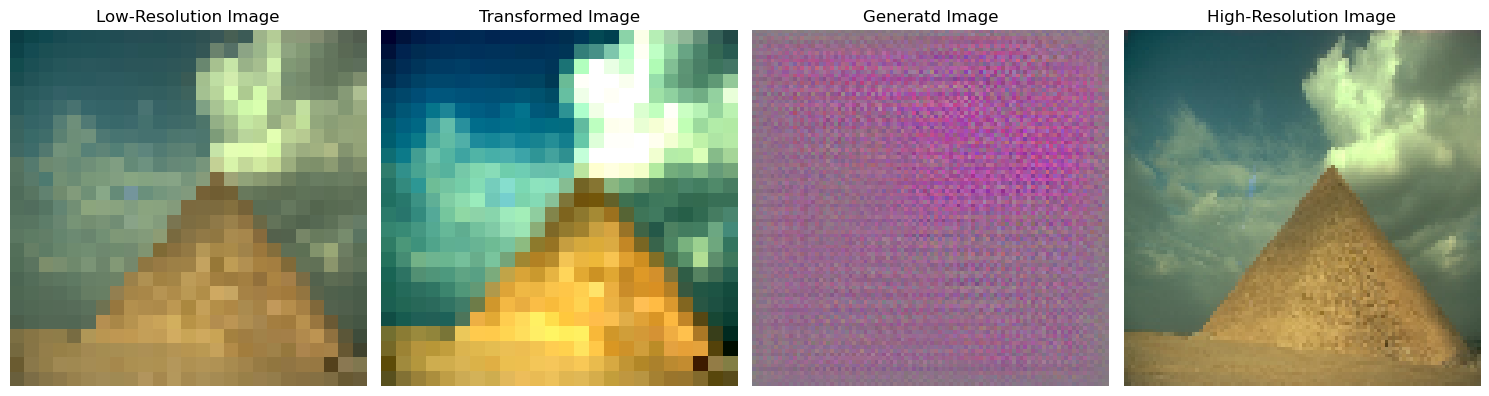

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


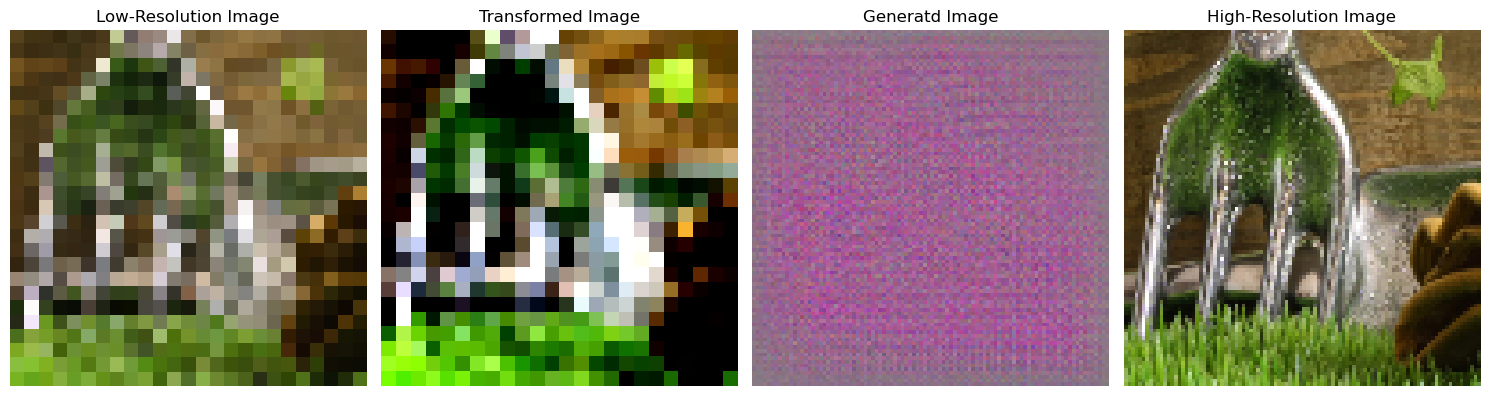

	g_loss.item() = 0.987522542476654, vgg_loss.item() = 0.9787188768386841, d_loss.item() = 0.00375622627325356
	g_loss.item() = 0.7742736339569092, vgg_loss.item() = 0.7650960087776184, d_loss.item() = 0.001652296632528305
	g_loss.item() = 1.066114902496338, vgg_loss.item() = 1.0569069385528564, d_loss.item() = 0.000451349769718945
	g_loss.item() = 0.988195538520813, vgg_loss.item() = 0.9790398478507996, d_loss.item() = 0.0008782717050053179
	g_loss.item() = 0.7947930097579956, vgg_loss.item() = 0.7855628728866577, d_loss.item() = 0.00025179548538289964
	g_loss.item() = 0.8374256491661072, vgg_loss.item() = 0.8293354511260986, d_loss.item() = 0.0010265931487083435
	g_loss.item() = 0.8569233417510986, vgg_loss.item() = 0.8487842082977295, d_loss.item() = 0.0019451930420473218
	g_loss.item() = 1.0378391742706299, vgg_loss.item() = 1.0288164615631104, d_loss.item() = 0.005765832029283047
epoch = 1 {'g_loss': 0.9178859740495682, 'd_loss': 0.0019659447607409675, 'vgg_loss': 0.909032583236694

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


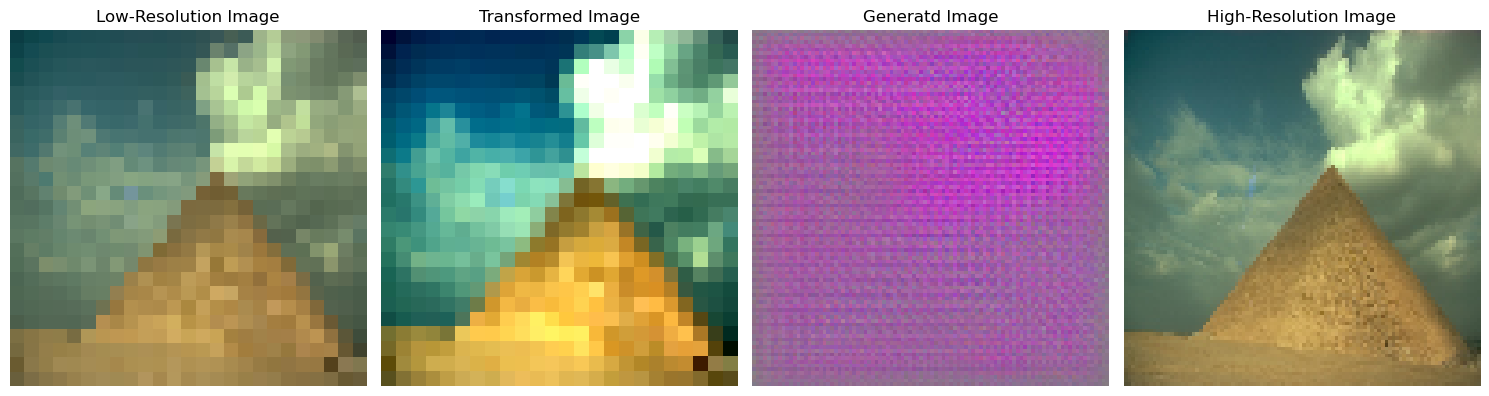

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


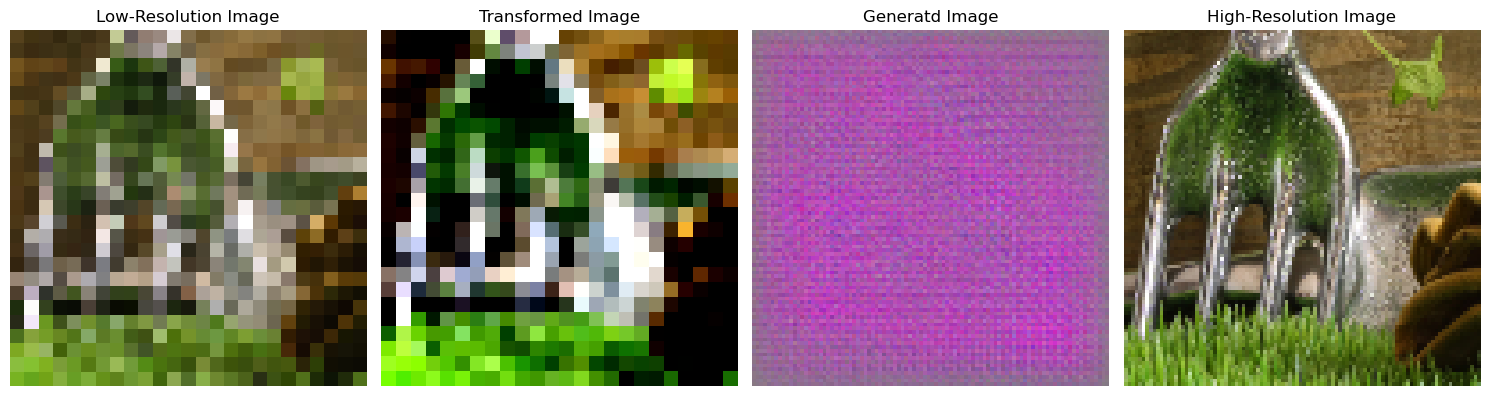

In [12]:
G = Generator(in_channels=3).to(DEVICE)
G_optimizer = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

D = Discriminator(3).to(DEVICE)
D_optimizer = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))


if False:
    load_checkpoint(CHECKPOINT_GEN, G, G_optimizer, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC, D, D_optimizer, LEARNING_RATE)
    print("Loaded Model Successfully")

training_metric = {"g_loss": [], "d_loss": [], "vgg_loss": [], "l2_loss": []}

for epoch in range(2):
    epoch_metric, D, G, G_optimizer, D_optimizer = train_epoch(dataloader, D, G, G_optimizer, D_optimizer, 
                                                               nn.MSELoss(), nn.BCEWithLogitsLoss(), VGGLoss())

    for key in epoch_metric.keys():
        training_metric[key].append(np.mean(epoch_metric[key]))
    print(f"{epoch = }", {k: training_metric[k][-1] for k in training_metric.keys()})

    if SAVE_MODEL:
        save_checkpoint(G, G_optimizer, filename=CHECKPOINT_GEN)
        save_checkpoint(D, D_optimizer, filename=CHECKPOINT_DISC)
        
    plot_examples(base_data_path, G)

# Model Evaluation

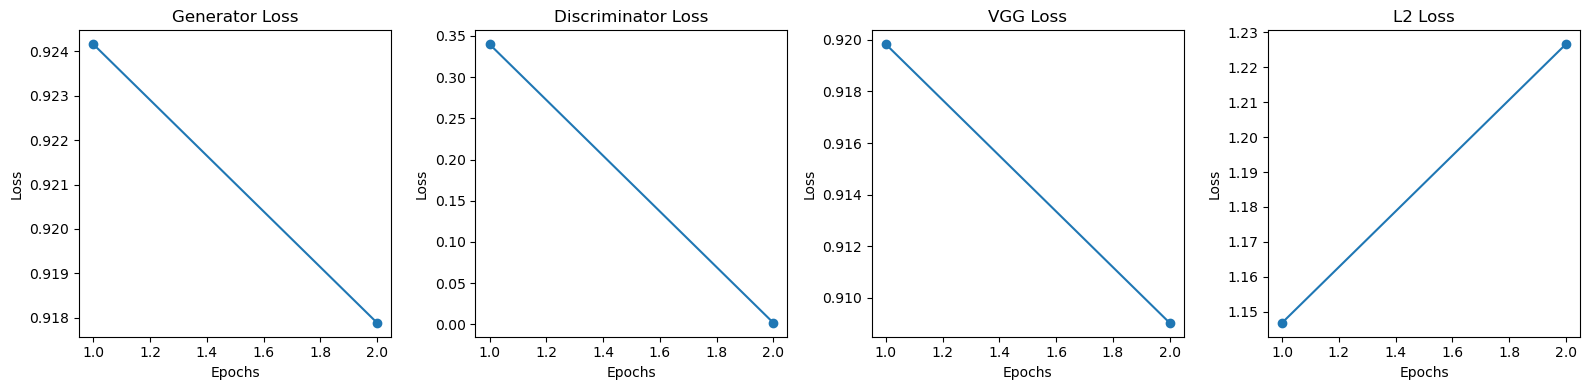

In [13]:
def plot_training_metrics(training_metric):
    num_epochs = len(training_metric['g_loss'])
    epochs = np.arange(1, num_epochs + 1)  # Assuming start from 1, adjust if needed

    # Plotting side by side without epoch axis
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # Plot g_loss
    axs[0].plot(epochs, training_metric['g_loss'], marker='o')
    axs[0].set_title('Generator Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    # Plot d_loss
    axs[1].plot(epochs, training_metric['d_loss'], marker='o')
    axs[1].set_title('Discriminator Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')

    # Plot vgg_loss
    axs[2].plot(epochs, training_metric['vgg_loss'], marker='o')
    axs[2].set_title('VGG Loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Loss')

    # Plot l2_loss
    axs[3].plot(epochs, training_metric['l2_loss'], marker='o')
    axs[3].set_title('L2 Loss')
    axs[3].set_xlabel('Epochs')
    axs[3].set_ylabel('Loss')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
    
plot_training_metrics(training_metric)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Showing Sample images generated by the model


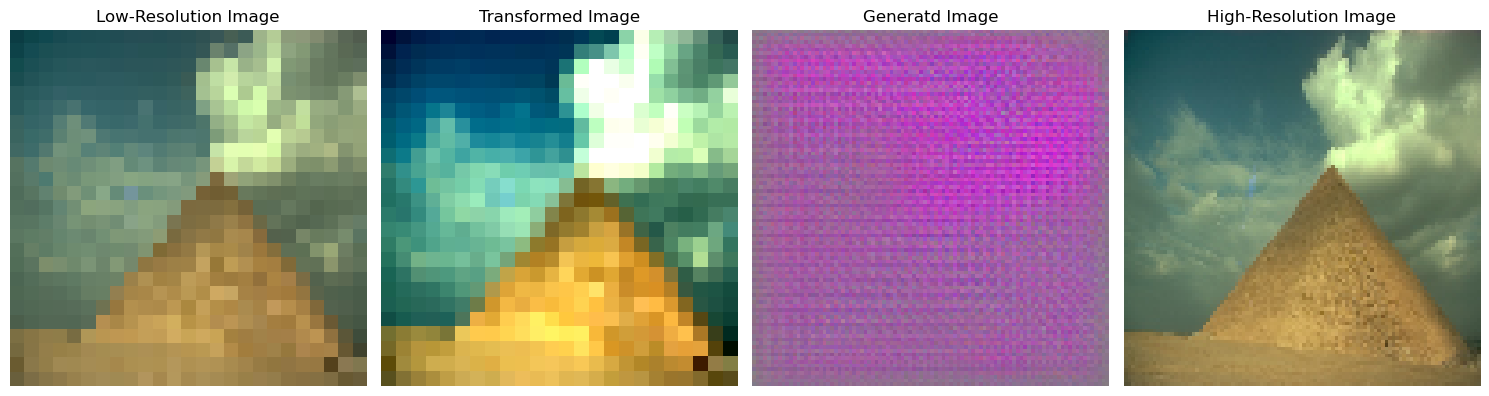

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


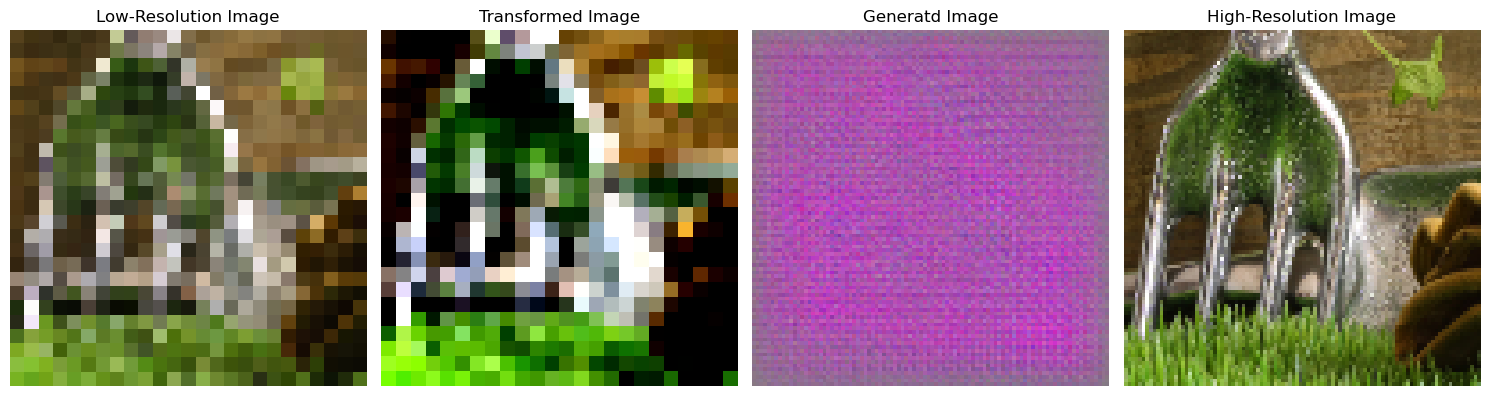

In [14]:
print("Showing Sample images generated by the model")
plot_examples(base_data_path, G)

In [15]:
# num_epochs = len(training_metric['g_loss'])
# epochs = np.arange(1, num_epochs + 1)  # Assuming start from 1, adjust if needed

# # Plotting side by side without epoch axis
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# # Plot g_loss
# axs[0].plot(epochs, training_metric['g_loss'], marker='o')
# axs[0].set_title('Generator Loss')
# axs[0].set_xlabel('Epochs')
# axs[0].set_ylabel('Loss')

# # Plot d_loss
# axs[1].plot(epochs, training_metric['d_loss'], marker='o')
# axs[1].set_title('Discriminator Loss')
# axs[1].set_xlabel('Epochs')
# axs[1].set_ylabel('Loss')

# # Plot vgg_loss
# axs[2].plot(epochs, training_metric['vgg_loss'], marker='o')
# axs[2].set_title('VGG Loss')
# axs[2].set_xlabel('Epochs')
# axs[2].set_ylabel('Loss')

# # Plot l2_loss
# axs[3].plot(epochs, training_metric['l2_loss'], marker='o')
# axs[3].set_title('L2 Loss')
# axs[3].set_xlabel('Epochs')
# axs[3].set_ylabel('Loss')

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()

In [16]:
# import torch
# from torch import nn


# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, activation_func=None, normalize=True, **kwargs):
#         super().__init__()
#         self.activation_func = activation_func
#         self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not normalize)
#         self.batchNorm = nn.BatchNorm2d(out_channels) if normalize else nn.Identity()

#     def forward(self, x):
#         out = self.batchNorm(self.cnn(x))
#         if self.activation_func is not None:
#             out = self.activation_func(out)
#         return out
#         # return self.act(self.batchNorm(self.cnn(x))) if self.use_act else self.batchNorm(self.cnn(x))


# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels):
#         super().__init__()
#         self.activation_func = nn.PReLU(num_parameters=in_channels)
#         # first three layer of the residual block
#         self.block_with_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1, activation_func=self.activation_func)
#         # later 2 layer of the residual block
#         self.block_wo_act = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

#     def forward(self, x):
#         out = self.block_with_act(x)
#         out = self.block_wo_act(out)
#         return out + x


# class PixelShufflerBlock(nn.Module):
#     def __init__(self, in_channels, scale_factor):
#         super().__init__()
#         out_channels = in_channels * scale_factor ** 2
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1) # in_c * 4, H, W --> in_c, H*2, W*2
#         self.pixel_shuffle = nn.PixelShuffle(scale_factor)
#         self.activation_function = nn.PReLU(num_parameters=in_channels)

#     def forward(self, x):
#         out = self.conv(x)
#         out = self.pixel_shuffle(out)
#         out = self.activation_function(out)
#         return out # return self.act(self.pixel_shuffle(self.conv(x)))


# class Generator(nn.Module):
#     def __init__(self, in_channels=3, num_channels=64, num_res_blocks=16, num_pix_shuffle_blocks=2):
#         super().__init__()
#         self.first_layer = ConvBlock(in_channels, num_channels, activation_func=nn.PReLU(num_parameters=num_channels), kernel_size=9, stride=1, padding=4, normalize=False)
#         self.residual_layer = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_res_blocks)])
#         self.conv_layer = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
#         self.pixel_shuffle_layer = nn.Sequential(*[PixelShufflerBlock(num_channels, scale_factor=2) for _ in range(num_pix_shuffle_blocks)])
#         self.output_layer = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

#     def forward(self, x):
#         initial = self.first_layer(x)
#         out = self.residual_layer(initial)
#         out = self.conv_layer(out) + initial
#         out = self.pixel_shuffle_layer(out)
#         out = self.output_layer(out)
#         out = torch.tanh(out)
#         return out


# class Discriminator(nn.Module):
#     def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
#         super().__init__()

#         activation_func = nn.LeakyReLU(0.2, inplace=True)
# #         layers = []
# #         for idx, feature in enumerate(features):
# #             stride = idx % 2 + 1
# #             normalize = False if idx == 0 else True
# #             layers.append(
# #                 ConvBlock(in_channels, feature, activation_func=activation_func, kernel_size=3, stride=stride, padding=1, normalize=normalize)
# #             )
# #             in_channels = feature

# #         self.layers = nn.Sequential(*layers)
        
#         self.layers = nn.Sequential(*[
#             ConvBlock(in_channels, 64,  activation_func=activation_func, kernel_size=3, stride=1, padding=1, normalize=False),
#             ConvBlock(64,  64,  activation_func=activation_func, kernel_size=3, stride=2, padding=1, normalize=True),
#             ConvBlock(64,  128, activation_func=activation_func, kernel_size=3, stride=1, padding=1, normalize=True),
#             ConvBlock(128, 128, activation_func=activation_func, kernel_size=3, stride=2, padding=1, normalize=True),
#             ConvBlock(128, 256, activation_func=activation_func, kernel_size=3, stride=1, padding=1, normalize=True),
#             ConvBlock(256, 256, activation_func=activation_func, kernel_size=3, stride=2, padding=1, normalize=True),
#             ConvBlock(256, 512, activation_func=activation_func, kernel_size=3, stride=1, padding=1, normalize=True),
#             ConvBlock(512, 512, activation_func=activation_func, kernel_size=3, stride=2, padding=1, normalize=True)
#         ])
#         self.classifier = nn.Sequential(
#             nn.AdaptiveAvgPool2d((6, 6)),
#             nn.Flatten(),
#             nn.Linear(512 * 6 * 6, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(1024, 1),
#         )

#     def forward(self, x):
#         x = self.layers(x)
#         return self.classifier(x)


# def test():
#     low_resolution = 24  # 96x96 -> 24x24
#     with torch.cuda.amp.autocast():
#         x = torch.randn((5, 3, low_resolution, low_resolution))
#         gen = Generator()
#         gen_out = gen(x)
#         # print(gen)
#         print(gen_out.shape)
#         disc = Discriminator()
#         # print(disc)
#         disc_out = disc(gen_out)
#         print(disc_out.shape)


# if __name__ == "__main__":
#     test()


In [17]:
# import glob
# import random
# import os
# import numpy as np

# import torch
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# import torchvision.transforms as transforms

# # Normalization parameters for pre-trained PyTorch models
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

# class ImagePairDataset(Dataset):
#     def __init__(self, root, hr_shape):
#         hr_height, hr_width = hr_shape
#         self.lr_transform = transforms.Compose([
#             transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
#             transforms.ToTensor(),
#             transforms.Normalize(mean, std),
#         ])
#         self.hr_transform = transforms.Compose([
#             transforms.Resize((hr_height, hr_height), Image.BICUBIC),
#             transforms.ToTensor(),
#             transforms.Normalize(mean, std),
#         ])

#         self.lr_files = sorted(glob.glob(root + "/LR/*.*"))
#         self.hr_files = sorted(glob.glob(root + "/HR/*.*"))

#     def __getitem__(self, index):
#         # Load the LR and HR images
#         # img_lr = Image.open(self.files[index * 2])  # LR image
#         # img_hr = Image.open(self.files[index * 2 + 1])  # HR image
        
#         img_lr = Image.open(self.lr_files[index])  # LR image
#         img_hr = Image.open(self.hr_files[index])  # HR image


#         img_lr = self.lr_transform(img_lr)
#         img_hr = self.hr_transform(img_hr)

#         return {"lr": img_lr, "hr": img_hr}

#     def __len__(self):
#         return len(self.lr_files) // 2  # Each pair counts as one sample

# # Example usage:
# dataset = ImagePairDataset("/Users/hims/Downloads/SRGAN_Data/", hr_shape=(96, 96))
# print(dataset)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [18]:
# import torch.nn as nn
# from torchvision.models import vgg19

# # phi_5,4 5th conv layer before maxpooling but after activation
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# class VGGLoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.vgg = vgg19(pretrained=True).features[:36].eval().to(DEVICE)
#         self.loss = nn.MSELoss()

#         for param in self.vgg.parameters():
#             param.requires_grad = False

#     def forward(self, input, target):
#         vgg_input_features = self.vgg(input)
#         vgg_target_features = self.vgg(target)
#         return self.loss(vgg_input_features, vgg_target_features)

In [19]:
# import torch
# from PIL import Image
# # import albumentations as A

# LOAD_MODEL = True
# SAVE_MODEL = True
# CHECKPOINT_GEN = "gen.pth.tar"
# CHECKPOINT_DISC = "disc.pth.tar"
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# LEARNING_RATE = 1e-4
# NUM_EPOCHS = 2
# BATCH_SIZE = 16
# NUM_WORKERS = 4
# HIGH_RES = 96
# LOW_RES = HIGH_RES // 4
# IMG_CHANNELS = 3


In [20]:
# import torch
# import os
# import numpy as np
# from PIL import Image
# from torchvision.utils import save_image


# def gradient_penalty(critic, real, fake, device):
#     BATCH_SIZE, C, H, W = real.shape
#     alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
#     interpolated_images = real * alpha + fake.detach() * (1 - alpha)
#     interpolated_images.requires_grad_(True)

#     # Calculate critic scores
#     mixed_scores = critic(interpolated_images)

#     # Take the gradient of the scores with respect to the images
#     gradient = torch.autograd.grad(
#         inputs=interpolated_images,
#         outputs=mixed_scores,
#         grad_outputs=torch.ones_like(mixed_scores),
#         create_graph=True,
#         retain_graph=True,
#     )[0]
#     gradient = gradient.view(gradient.shape[0], -1)
#     gradient_norm = gradient.norm(2, dim=1)
#     gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
#     return gradient_penalty


# def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
#     print("=> Saving checkpoint")
#     checkpoint = {
#         "state_dict": model.state_dict(),
#         "optimizer": optimizer.state_dict(),
#     }
#     torch.save(checkpoint, filename)


# def load_checkpoint(checkpoint_file, model, optimizer, lr):
#     print("=> Loading checkpoint")
#     checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
#     model.load_state_dict(checkpoint["state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer"])

#     # If we don't do this then it will just have learning rate of old checkpoint
#     # and it will lead to many hours of debugging \:
#     for param_group in optimizer.param_groups:
#         param_group["lr"] = lr


# import os
# import torch
# import torchvision.transforms as transforms
# from PIL import Image
# import matplotlib.pyplot as plt

# # Assuming 'gen' is your PyTorch generator model

# def plot_examples(low_res_folder, gen):
#     files = os.listdir(low_res_folder)
    
#     ts = transforms.Compose([
#             transforms.Resize((50, 50), Image.BICUBIC),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])

#     gen.eval()
#     for file in sorted(files):
#         image_path = os.path.join(low_res_folder, file)
#         image = Image.open(image_path)
#         plt.figure(figsize=(5, 5))
#         plt.imshow(image)
#         plt.axis('off')
#         plt.title('Low-Resolution Image')
#         plt.show()

#         with torch.no_grad():
#             upscaled_img = ts(image).unsqueeze(0)
#             gen_output = gen(upscaled_img)
        
#         plt.figure(figsize=(5, 5))
#         plt.imshow((upscaled_img.squeeze().permute(1, 2, 0).cpu().numpy() + 1) * 0.5)
#         plt.axis('off')
#         plt.title('Transformed Image')
#         plt.show()
        
#         gen_output = (gen_output.squeeze().permute(1, 2, 0).cpu().numpy() + 1) * 0.5
#         plt.figure(figsize=(5, 5))
#         plt.imshow(gen_output)
#         plt.axis('off')
#         plt.title('Generated High-Resolution Image')
#         plt.show()
        
#         break

In [21]:
# import torch
# # import config
# from torch import nn
# from torch import optim
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# torch.backends.cudnn.benchmark = True


# def train_fn(loader, D, G, opt_gen, opt_disc, mse_loss, bce_loss, vgg_loss_fun):
    
#     training_metric = {"g_loss": [], "d_loss": [], "vgg_loss": [], "l2_loss": []}
#     for i, imgs in enumerate(loader):
#         low_res = imgs['lr'].to(DEVICE)
#         high_res = imgs['hr'].to(DEVICE)
        
#         ### Train Discriminator
#         opt_disc.zero_grad()
        
#         output = G(low_res)
#         d_real = D(high_res)
#         d_fake = D(output.detach())
        
#         d_real_loss = bce_loss(d_real, torch.ones_like(d_real))# - 0.1 * torch.rand_like(d_real))
#         d_fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))
#         d_loss = (d_real_loss + d_fake_loss)/2

#         # opt_disc.zero_grad()
#         d_loss.backward()
#         opt_disc.step()

#         # Train Generator
#         opt_gen.zero_grad()
        
#         output = G(low_res)
#         d_fake = D(output)
        
        
#         adversarial_loss = 1e-3 * bce_loss(d_fake, torch.ones_like(d_fake))
#         vgg_loss = vgg_loss_fun(output, high_res) # * 0.006
#         g_loss = adversarial_loss + vgg_loss
#         l2_loss = mse_loss(output, high_res)
        
        
#         # opt_gen.zero_grad()
#         g_loss.backward()
#         opt_gen.step()
        
#         # if (i+1)%(len(loader)//2) == 0:
#         print(f"\t{g_loss.item() = }, {vgg_loss.item() = }, {d_loss.item() = }")
#         training_metric["g_loss"].append(g_loss.item())
#         training_metric["d_loss"].append(d_loss.item())
#         training_metric["vgg_loss"].append(vgg_loss.item())
#         training_metric["l2_loss"].append(l2_loss.item())

#         # if idx % 200 == 0:
#         #     plot_examples("/Users/hims/Downloads/SRGAN_Data/Test/", gen)
#     return training_metric 


# def main():
#     loader = dataloader
#     gen = Generator(in_channels=3).to(DEVICE)
#     disc = Discriminator(3).to(DEVICE)
#     opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
#     opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
#     mse = nn.MSELoss()
#     bce = nn.BCEWithLogitsLoss()
#     vgg_loss = VGGLoss()

#     if False:
#         load_checkpoint(
#             CHECKPOINT_GEN,
#             gen,
#             opt_gen,
#             LEARNING_RATE,
#         )
#         load_checkpoint(
#            CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
#         )
#         print("loaded success fully")
    
#     training_metric = {"g_loss": [], "d_loss": [], "vgg_loss": [], "l2_loss": []}
#     for epoch in range(16):
#         epoch_metric = train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
        
#         for key in epoch_metric.keys():
#             training_metric[key].append(np.mean(epoch_metric[key]))
#         print(f"{epoch = }", {k: training_metric[k][-1] for k in training_metric.keys()})
        
#         if SAVE_MODEL:
#             save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
#             save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)
#         plot_examples("/Users/hims/Downloads/SRGAN_Data/Test/", gen)    
        

# gen = Generator(in_channels=3).to(DEVICE)
# disc = Discriminator(3).to(DEVICE)
# opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
# opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
# mse = nn.MSELoss()
# bce = nn.BCEWithLogitsLoss()
# vgg_loss = VGGLoss()
    
# main()

In [22]:
# import os
# import torch
# import matplotlib.pyplot as plt
# from torchvision import transforms
# from PIL import Image

# # Assuming 'gen' is your PyTorch generator model

# def plot_examples(low_res_folder, gen):
#     files = os.listdir(low_res_folder)
    
#     ts = transforms.Compose([
#             transforms.Resize((24, 24), Image.BICUBIC),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])

#     gen.eval()
#     for file in sorted(files):
#         image_path = os.path.join(low_res_folder, file)
#         image = Image.open(image_path)
        
#         # Display low-resolution image
#         plt.figure(figsize=(15, 5))
#         plt.subplot(1, 3, 1)
#         plt.imshow(image)
#         plt.axis('off')
#         plt.title('Low-Resolution Image')
        
#         upscaled_img = ts(image).unsqueeze(0)
#         plt.subplot(1, 3, 2)
#         plt.imshow((upscaled_img.squeeze().permute(1, 2, 0).cpu().detach().numpy() + 1 ) * 0.5)
#         plt.axis('off')
#         plt.title('Transformed Image')
        
#         # Display transformed image
#         with torch.no_grad():
#             # Display generated high-resolution image
#             gen_output = gen(upscaled_img)
#             gen_output = (gen_output.squeeze().permute(1, 2, 0).cpu().detach().numpy()+1) * 0.5
#             plt.subplot(1, 3, 3)
#             plt.imshow(gen_output)
#             plt.axis('off')
#             plt.title('Generated High-Resolution Image')
        
#         plt.tight_layout()
#         plt.show()
        
#         break  # Remove this line if you want to display for all images

# plot_examples("/Users/hims/Downloads/SRGAN_Data/LR/", gen)

In [23]:
# training_metric = {
#     'g_loss': [],
#     'd_loss': [],
#     'vgg_loss': [],
#     'l2_loss': []
# }

# lines = """
# epoch = 0 {'g_loss': 0.9253623634576797, 'd_loss': 0.31363235926255584, 'vgg_loss': 0.9214701056480408, 'l2_loss': 1.1469535380601883}
# epoch = 1 {'g_loss': 0.9171243235468864, 'd_loss': 0.008325307477207389, 'vgg_loss': 0.9081797674298286, 'l2_loss': 1.1949388533830643}
# epoch = 2 {'g_loss': 0.9171842634677887, 'd_loss': 0.002586892205727054, 'vgg_loss': 0.9045401364564896, 'l2_loss': 1.1838962882757187}
# epoch = 3 {'g_loss': 0.9210297539830208, 'd_loss': 0.002285364980707527, 'vgg_loss': 0.9040256515145302, 'l2_loss': 1.1734744384884834}
# epoch = 4 {'g_loss': 0.9248893931508064, 'd_loss': 0.0024235161317847087, 'vgg_loss': 0.9065550044178963, 'l2_loss': 1.2041715383529663}
# epoch = 5 {'g_loss': 0.9199821576476097, 'd_loss': 0.0023432472703461826, 'vgg_loss': 0.9031233862042427, 'l2_loss': 1.2152902781963348}
# epoch = 6 {'g_loss': 0.920759379863739, 'd_loss': 0.010850422777963331, 'vgg_loss': 0.8980943635106087, 'l2_loss': 1.2235895246267319}
# epoch = 7 {'g_loss': 0.9177929386496544, 'd_loss': 0.006632984300144251, 'vgg_loss': 0.893947571516037, 'l2_loss': 1.2431645095348358}
# epoch = 8 {'g_loss': 0.917134054005146, 'd_loss': 0.01578825757401603, 'vgg_loss': 0.8911490589380264, 'l2_loss': 1.254276692867279}
# epoch = 9 {'g_loss': 0.9171968623995781, 'd_loss': 0.007034868082089751, 'vgg_loss': 0.8906358107924461, 'l2_loss': 1.254276692867279}
# epoch = 10 {'g_loss': 0.9118714109063148, 'd_loss': 0.09146013894532687, 'vgg_loss': 0.8857059255242348, 'l2_loss': 1.2247119396924973}
# epoch = 11 {'g_loss': 0.9123580381274223, 'd_loss': 0.06664369013844862, 'vgg_loss': 0.8845880553126335, 'l2_loss': 1.1941896677017212}
# epoch = 12 {'g_loss': 0.9067941531538963, 'd_loss': 0.014753234875799492, 'vgg_loss': 0.8827999979257584, 'l2_loss': 1.18085515499115}
# epoch = 13 {'g_loss': 0.9041623696684837, 'd_loss': 0.03214618143442749, 'vgg_loss': 0.8814720809459686, 'l2_loss': 1.16358882188797}
# """.strip().split('\n')

# for line in lines:
#     parts = line.split(' ')
#     training_metric['g_loss'].append(float(parts[4][:-1]))
#     training_metric['d_loss'].append(float(parts[6][:-1]))
#     training_metric['vgg_loss'].append(float(parts[8][:-1]))
#     training_metric['l2_loss'].append(float(parts[10][:-1]))

# print(training_metric)


# num_epochs = len(training_metric['g_loss'])
# epochs = np.arange(1, num_epochs + 1)  # Assuming start from 1, adjust if needed

# # Plotting side by side without epoch axis
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# # Plot g_loss
# axs[0].plot(epochs, training_metric['g_loss'], marker='o')
# axs[0].set_title('Generator Loss')
# axs[0].set_xlabel('Epochs')
# axs[0].set_ylabel('Loss')

# # Plot d_loss
# axs[1].plot(epochs, training_metric['d_loss'], marker='o')
# axs[1].set_title('Discriminator Loss')
# axs[1].set_xlabel('Epochs')
# axs[1].set_ylabel('Loss')

# # Plot vgg_loss
# axs[2].plot(epochs, training_metric['vgg_loss'], marker='o')
# axs[2].set_title('VGG Loss')
# axs[2].set_xlabel('Epochs')
# axs[2].set_ylabel('Loss')

# # Plot l2_loss
# axs[3].plot(epochs, training_metric['l2_loss'], marker='o')
# axs[3].set_title('L2 Loss')
# axs[3].set_xlabel('Epochs')
# axs[3].set_ylabel('Loss')

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()